**Loading Libraries**

In [2]:
# Load libraries
import datetime as dt
from datetime import datetime
import time 
import calendar
start_time = datetime.now()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print('LOAD DURATION:',datetime.now() - start_time)

LOAD DURATION: 0:00:01.192915


**Load Data**

In [3]:
%%time
df = pd.read_csv('applications data.csv')

CPU times: user 944 ms, sys: 108 ms, total: 1.05 s
Wall time: 1.05 s


In [4]:
# fix data type
df['date'] = pd.to_datetime(df.date.astype(str).apply(lambda x: x[:4]+'-' + x[4:6]+'-' + x[6:]))
df['zip5'] = df['zip5'].apply(lambda x: '{0:0>5}'.format(x))

#fix frivolous values
#ssn
df.loc[df.ssn == 999999999, 'ssn'] = -df[df.ssn==999999999]['record']
df['ssn'] = df['ssn'].apply(lambda x: '{0:0>9}'.format(x))

#address
df.loc[df.address=='123 MAIN ST', 'address'] = \
    df.loc[df.address=='123 MAIN ST', 'record'].apply(lambda x: str(x) + ' RECORD')

#dob
df.loc[df.dob==19070626, 'dob'] = -df.loc[df.dob==19070626]['record']
df['dob'] = df['dob'].apply(lambda x: '{0:0>8}'.format(x))

#homephone
df.loc[df.homephone==9999999999, 'homephone'] = -df.loc[df.homephone==9999999999]['record']
df['homephone'] = df['homephone'].apply(lambda x: '{0:0>10}'.format(x))

In [5]:
df.head(3)

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,02765,000000-1,1797504115,0
1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,000000-3,0216537580,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   record       1000000 non-null  int64         
 1   date         1000000 non-null  datetime64[ns]
 2   ssn          1000000 non-null  object        
 3   firstname    1000000 non-null  object        
 4   lastname     1000000 non-null  object        
 5   address      1000000 non-null  object        
 6   zip5         1000000 non-null  object        
 7   dob          1000000 non-null  object        
 8   homephone    1000000 non-null  object        
 9   fraud_label  1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 76.3+ MB


**Risk Table for day of week**

In [7]:
df['dow'] = df.date.apply(lambda x: calendar.day_name[x.weekday()])

In [8]:
train_test = df[df.date < '2016-11-01']

In [9]:
# statistical smoothing
c = 4; nmid = 20; y_avg = train_test['fraud_label'].mean()
y_dow = train_test.groupby('dow')['fraud_label'].mean()
num = train_test.groupby('dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/(1 + np.exp(-(num - nmid)/c))
df['dow_risk'] = df.dow.map(y_dow_smooth)

In [10]:
y_dow = y_dow.reset_index()

cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']
y_dow['dow'] = pd.Categorical(y_dow['dow'], categories=cats, ordered=True)
y_dow = y_dow.sort_values('dow')
y_dow = y_dow.set_index('dow')

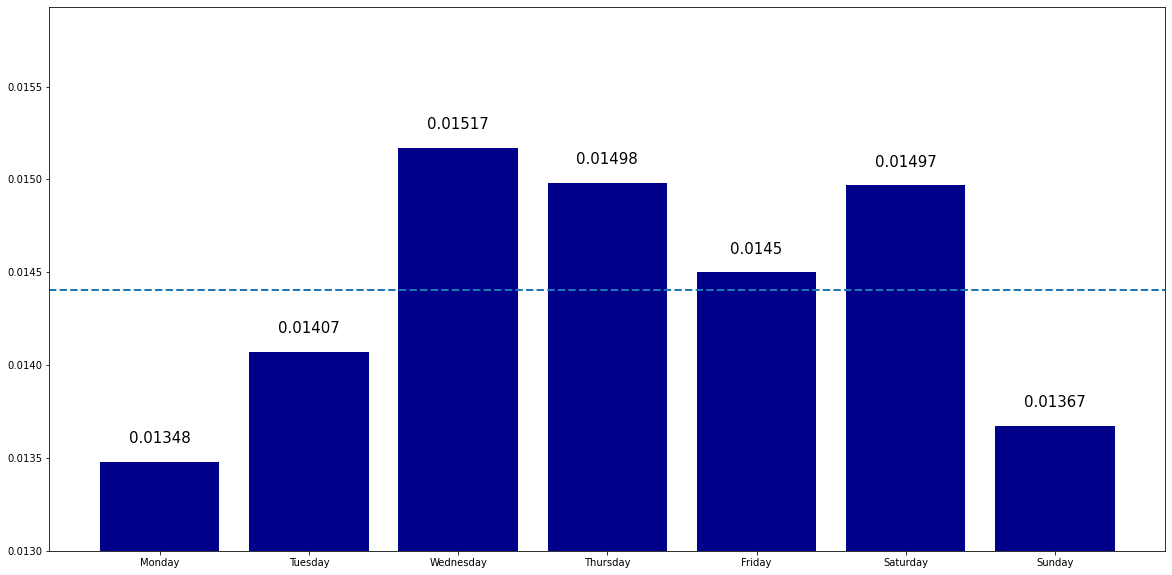

In [11]:
# plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data=y_dow, x=y_dow.index, height='fraud_label', color='darkblue')
ax.set_ylim(bottom=0.013)
ax.axhline(y=y_avg, ls='--', lw=2)

for i, v in enumerate(y_dow.index):
    ax.text(v,y_dow.loc[i,'fraud_label']+0.0001,round(y_dow.loc[i,'fraud_label'],5),
            horizontalalignment='center',fontsize=15)

plt.show()

**Create Entities**

- name: firstname + lastname
- fulladdress: address + zip5
- unusable columns: record, fraud_label, date
- remaining columns:
    - ssn
    - dob
    - homephone

In [12]:
df['name'] = df.firstname + df.lastname
df['fulladdress'] = df.address + df.zip5
df['name_dob'] = df.name + df.dob
df['name_fulladdress'] = df.name + df.fulladdress
df['name_homephone'] = df.name + df.homephone
df['fulladdress_dob'] = df.fulladdress + df.dob
df['fulladdress_homephone'] = df.fulladdress + df.homephone
df['dob_homephone'] = df.dob + df.homephone
df['homephone_name_dob'] = df.homephone + df.name_dob

In [13]:
df.columns

Index(['record', 'date', 'ssn', 'firstname', 'lastname', 'address', 'zip5',
       'dob', 'homephone', 'fraud_label', 'dow', 'dow_risk', 'name',
       'fulladdress', 'name_dob', 'name_fulladdress', 'name_homephone',
       'fulladdress_dob', 'fulladdress_homephone', 'dob_homephone',
       'homephone_name_dob'],
      dtype='object')

In [14]:
for field in list(df.iloc[:,np.r_[3:9, 12:15]].columns):
    df['ssn_'+field] = df.ssn + df[field]

In [15]:
df.columns

Index(['record', 'date', 'ssn', 'firstname', 'lastname', 'address', 'zip5',
       'dob', 'homephone', 'fraud_label', 'dow', 'dow_risk', 'name',
       'fulladdress', 'name_dob', 'name_fulladdress', 'name_homephone',
       'fulladdress_dob', 'fulladdress_homephone', 'dob_homephone',
       'homephone_name_dob', 'ssn_firstname', 'ssn_lastname', 'ssn_address',
       'ssn_zip5', 'ssn_dob', 'ssn_homephone', 'ssn_name', 'ssn_fulladdress',
       'ssn_name_dob'],
      dtype='object')

In [16]:
attributes = list(df.iloc[:, np.r_[2, 5, 7, 8, 12:30]].columns)

**Attributes:**
['ssn','address',
 'dob',
 'homephone',
 'name',
 'fulladdress',
 'name_dob',
 'name_fulladdress',
 'name_homephone',
 'fulladdress_dob',
 'fulladdress_homephone',
 'dob_homephone',
 'homephone_name_dob',
 'ssn_firstname',
 'ssn_lastname',
 'ssn_address',
 'ssn_zip5',
 'ssn_dob',
 'ssn_homephone',
 'ssn_name',
 'ssn_fulladdress',
 'ssn_name_dob']

In [17]:
df1 = df.copy()
final = df.copy()
df1['check_date'] = df1.date
df1['check_record'] = df1.record

In [18]:
begin = time.time()
for entity in attributes:
    st = time.time()
    df_1 = df1[['record', 'date', entity]]
    df_r = df1[['check_record', 'check_date', entity]]
    temp = pd.merge(df_1, df_r, left_on=entity, right_on=entity)
    
    #day since
    day_since_df = temp[temp.record > temp.check_record][['record', 'date', 'check_date']] \
                    .groupby('record')[['date','check_date']].last()
    mapper = (day_since_df.date - day_since_df.check_date).dt.days
    final[entity + '_day_since'] = final.record.map(mapper)
    final[entity + '_day_since'].fillna(365, inplace=True)
    print(f'\n{entity}_day_since ---> Done')
    
    #velocity
    for offset_t in [0, 1, 3, 7, 14, 30]:
        count_day_df = temp[(temp.check_date >= (temp.date - dt.timedelta(offset_t)))
                            & (temp.record >= temp.check_record)]
        col_name = f'{entity}_count_{offset_t}'
        mapper2 = count_day_df.groupby('record')[entity].count()
        final[col_name] = final.record.map(mapper2)
        
        print(f'{entity}_count_{str(offset_t)} ---> Done')
        
    print(f'Run time for entity {entity} ------------- {time.time() - st}s')

print(f'Total run time: {(time.time() - begin) / 60}min')


ssn_day_since ---> Done
ssn_count_0 ---> Done
ssn_count_1 ---> Done
ssn_count_3 ---> Done
ssn_count_7 ---> Done
ssn_count_14 ---> Done
ssn_count_30 ---> Done
Run time for entity ssn ------------- 3.5872530937194824s

address_day_since ---> Done
address_count_0 ---> Done
address_count_1 ---> Done
address_count_3 ---> Done
address_count_7 ---> Done
address_count_14 ---> Done
address_count_30 ---> Done
Run time for entity address ------------- 3.7269232273101807s

dob_day_since ---> Done
dob_count_0 ---> Done
dob_count_1 ---> Done
dob_count_3 ---> Done
dob_count_7 ---> Done
dob_count_14 ---> Done
dob_count_30 ---> Done
Run time for entity dob ------------- 18.694761037826538s

homephone_day_since ---> Done
homephone_count_0 ---> Done
homephone_count_1 ---> Done
homephone_count_3 ---> Done
homephone_count_7 ---> Done
homephone_count_14 ---> Done
homephone_count_30 ---> Done
Run time for entity homephone ------------- 14.69906210899353s

name_day_since ---> Done
name_count_0 ---> Done
name

In [19]:
start = time.time()
for att in attributes:
    for d in ['0', '1']:
        for dd in ['3', '7', '14', '30']:
             final[att + '_count_' + d + '_by_' + dd] \
                = final[att + '_count_' + d] / (final[att + '_count_' + dd] / float(dd))
print(f'Total run time: {time.time() - start}s')

Total run time: 4.848244905471802s


In [21]:
final.to_csv('candidate_var_hw7.csv')

**Number of Unique in Particular Entity over Past N Days**

In [19]:
# modified based on the prior for loop
# this takes around 70 min to run
# replaced 0 days with 60 days
begin = time.time()
for entity in attributes:
    for field in attributes:
        st = time.time()
        if field == entity:
            continue
        else:
            df_c = df1[['record', 'date', entity]]
            df_d = df1[['check_record', 'check_date', entity,field]]
            temp = pd.merge(df_c, df_d, left_on=entity, right_on=entity)

        # number of unique for particular field
        for offset_t in [1, 3, 7, 14, 30, 60]:
            count_day_df = temp[(temp.check_date >= (temp.date - dt.timedelta(offset_t)))
                                & (temp.record >= temp.check_record)]
            col_name = f'{entity}_unique_count_for_{field}_{offset_t}'
            mapper = count_day_df.groupby(['record'])[field].nunique()
            final[col_name] = final.record.map(mapper)

        print(f'Run time for entity {entity} in field {field}------------- {time.time() - st}s')

    print(f'Total run time: {(time.time() - begin) / 60}min')

Run time for entity ssn in field address------------- 5.486732006072998s
Run time for entity ssn in field dob------------- 5.045983076095581s
Run time for entity ssn in field homephone------------- 4.996290922164917s
Run time for entity ssn in field name------------- 5.009008884429932s
Run time for entity ssn in field fulladdress------------- 5.528486967086792s
Run time for entity ssn in field name_dob------------- 5.5657031536102295s
Run time for entity ssn in field name_fulladdress------------- 5.71871280670166s
Run time for entity ssn in field name_homephone------------- 5.651617050170898s
Run time for entity ssn in field fulladdress_dob------------- 5.681532859802246s
Run time for entity ssn in field fulladdress_homephone------------- 9.327647924423218s
Run time for entity ssn in field dob_homephone------------- 5.5063300132751465s
Run time for entity ssn in field homephone_name_dob------------- 5.742978096008301s
Run time for entity ssn in field ssn_firstname------------- 5.393007

Run time for entity name in field ssn_homephone------------- 6.327668905258179s
Run time for entity name in field ssn_name------------- 6.838735103607178s
Run time for entity name in field ssn_fulladdress------------- 7.214272737503052s
Run time for entity name in field ssn_name_dob------------- 6.6076600551605225s
Total run time: 22.21054096619288min
Run time for entity fulladdress in field ssn------------- 5.62744402885437s
Run time for entity fulladdress in field address------------- 15.442301034927368s
Run time for entity fulladdress in field dob------------- 5.311520576477051s
Run time for entity fulladdress in field homephone------------- 4.963632106781006s
Run time for entity fulladdress in field name------------- 5.156949043273926s
Run time for entity fulladdress in field name_dob------------- 5.739087104797363s
Run time for entity fulladdress in field name_fulladdress------------- 5.789484024047852s
Run time for entity fulladdress in field name_homephone------------- 5.6052253

Run time for entity fulladdress_dob in field name_dob------------- 5.717871189117432s
Run time for entity fulladdress_dob in field name_fulladdress------------- 6.122192859649658s
Run time for entity fulladdress_dob in field name_homephone------------- 5.757802963256836s
Run time for entity fulladdress_dob in field fulladdress_homephone------------- 5.604287147521973s
Run time for entity fulladdress_dob in field dob_homephone------------- 5.572903394699097s
Run time for entity fulladdress_dob in field homephone_name_dob------------- 5.916057825088501s
Run time for entity fulladdress_dob in field ssn_firstname------------- 5.685755968093872s
Run time for entity fulladdress_dob in field ssn_lastname------------- 5.538919925689697s
Run time for entity fulladdress_dob in field ssn_address------------- 28.671241760253906s
Run time for entity fulladdress_dob in field ssn_zip5------------- 5.745546102523804s
Run time for entity fulladdress_dob in field ssn_dob------------- 5.2030029296875s
Ru

Run time for entity ssn_firstname in field homephone_name_dob------------- 6.585417985916138s
Run time for entity ssn_firstname in field ssn_lastname------------- 6.08056116104126s
Run time for entity ssn_firstname in field ssn_address------------- 6.286075115203857s
Run time for entity ssn_firstname in field ssn_zip5------------- 5.864761829376221s
Run time for entity ssn_firstname in field ssn_dob------------- 5.97286581993103s
Run time for entity ssn_firstname in field ssn_homephone------------- 5.949010848999023s
Run time for entity ssn_firstname in field ssn_name------------- 5.958308935165405s
Run time for entity ssn_firstname in field ssn_fulladdress------------- 6.022696018218994s
Run time for entity ssn_firstname in field ssn_name_dob------------- 6.147833824157715s
Total run time: 45.094069314002994min
Run time for entity ssn_lastname in field ssn------------- 5.7345709800720215s
Run time for entity ssn_lastname in field address------------- 5.804399251937866s
Run time for en

Run time for entity ssn_homephone in field homephone------------- 66.56952810287476s
Run time for entity ssn_homephone in field name------------- 5.427810907363892s
Run time for entity ssn_homephone in field fulladdress------------- 6.424215078353882s
Run time for entity ssn_homephone in field name_dob------------- 6.577712774276733s
Run time for entity ssn_homephone in field name_fulladdress------------- 6.469271898269653s
Run time for entity ssn_homephone in field name_homephone------------- 6.455654859542847s
Run time for entity ssn_homephone in field fulladdress_dob------------- 6.528120040893555s
Run time for entity ssn_homephone in field fulladdress_homephone------------- 6.28090500831604s
Run time for entity ssn_homephone in field dob_homephone------------- 6.199465036392212s
Run time for entity ssn_homephone in field homephone_name_dob------------- 6.349950313568115s
Run time for entity ssn_homephone in field ssn_firstname------------- 6.2431769371032715s
Run time for entity ss

In [20]:
final.shape

(1000000, 3132)

In [21]:
final.to_csv('final_candidate_variables.csv')

In [22]:
output = final.copy()

In [25]:
final_output = output.describe().transpose()

In [28]:
final_output = final_output[['mean', 'std', 'min','max']]

In [29]:
final_output.head()

,mean,std,min,max
record,500000.500000,288675.278933,1.00000,1000000.000000
fraud_label,0.014393,0.119104,0.00000,1.000000
dow_risk,0.014410,0.000624,0.01348,0.015169
ssn_day_since,327.100964,96.645429,0.00000,365.000000
ssn_count_0,1.007305,0.223356,1.00000,21.000000


In [30]:
final_output.to_csv('candidate_var_summary_stats.csv')